In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('dialogues_text.csv', encoding = 'utf-8')
df

,Dialogue,Topic
0,The kitchen stinks . __eou__ I'll throw out th...,1
1,"So Dick , how about getting some coffee for to...",1
2,Are things still going badly with your housegu...,1
3,Would you mind waiting a while ? __eou__ Well ...,1
4,Are you going to the annual party ? I can give...,1
...,...,...
13113,You have done an excellent job this year and w...,10
13114,Lindsay Tipping gave me your name as a referen...,10
13115,The consignments of chemical instruments have ...,10
13116,good morning . How can I help you ? __eou__ I'...,10


In [3]:
def remove_eou(x):
    x = x.replace('__eou__', '')
    return x   
df['Dialogue'] = df['Dialogue'].apply(remove_eou)
df['Topic'] = df['Topic'].apply(lambda x: x-1)

Topic
0    3646
1     487
2      55
3     667
4    4391
5    1065
6     267
7    1924
8     131
9     485
Name: Dialogue, dtype: int64


<AxesSubplot:xlabel='Topic'>

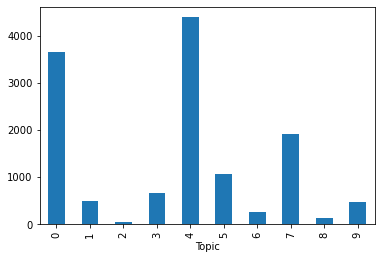

In [4]:
print(df.groupby('Topic')['Dialogue'].agg('count'))
df.groupby('Topic')['Dialogue'].agg('count').plot(kind='bar')

In [5]:
df.groupby('Topic')['Dialogue'].agg('count').min()

55

In [6]:
X = df['Dialogue'].values
y = df['Topic']
y

0        0
1        0
2        0
3        0
4        0
        ..
13113    9
13114    9
13115    9
13116    9
13117    9
Name: Topic, Length: 13118, dtype: int64

Word Embeddings

In [7]:
df

,Dialogue,Topic
0,The kitchen stinks . I'll throw out the garba...,0
1,"So Dick , how about getting some coffee for to...",0
2,Are things still going badly with your housegu...,0
3,"Would you mind waiting a while ? Well , how l...",0
4,Are you going to the annual party ? I can give...,0
...,...,...
13113,You have done an excellent job this year and w...,9
13114,Lindsay Tipping gave me your name as a referen...,9
13115,The consignments of chemical instruments have ...,9
13116,good morning . How can I help you ? I'd like ...,9


In [8]:
# import nltk
# nltk.download('stopwords')

In [9]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


dialogues = df["Dialogue"].values.tolist()

tokenized_dialogues = []

for dialogue in dialogues:
    tokens = word_tokenize(dialogue)
    tokens = [word.lower() for word in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    tokenized_dialogues.append(words)

In [10]:
tokenized_dialogues

[['kitchen', 'stinks', 'throw', 'garbage'],
 ['dick',
  'getting',
  'coffee',
  'tonight',
  'coffee',
  'honestly',
  'like',
  'kind',
  'stuff',
  'come',
  'least',
  'try',
  'little',
  'besides',
  'cigarette',
  'wrong',
  'cigarette',
  'thing',
  'go',
  'crazy',
  'dick'],
 ['things',
  'still',
  'going',
  'badly',
  'houseguest',
  'getting',
  'worse',
  'eating',
  'house',
  'home',
  'tried',
  'talking',
  'goes',
  'one',
  'ear',
  'makes',
  'home',
  'fine',
  'really',
  'gets',
  'yesterday',
  'walked',
  'living',
  'room',
  'raw',
  'company',
  'last',
  'straw',
  'leo',
  'really',
  'think',
  'beating',
  'around',
  'bush',
  'guy',
  'know',
  'used',
  'best',
  'friend',
  'college',
  'really',
  'think',
  'time',
  'lay',
  'law',
  'right',
  'everything',
  'probably',
  'going',
  'come',
  'head',
  'tonight',
  'keep',
  'informed'],
 ['would',
  'mind',
  'waiting',
  'well',
  'long',
  'sure',
  'get',
  'table',
  'ready',
  'fast',
  

In [11]:
len(tokenized_dialogues)

13118

In [12]:
max_length = max([len(s.split()) for s in dialogues])

In [13]:
tokenized_dialogues

[['kitchen', 'stinks', 'throw', 'garbage'],
 ['dick',
  'getting',
  'coffee',
  'tonight',
  'coffee',
  'honestly',
  'like',
  'kind',
  'stuff',
  'come',
  'least',
  'try',
  'little',
  'besides',
  'cigarette',
  'wrong',
  'cigarette',
  'thing',
  'go',
  'crazy',
  'dick'],
 ['things',
  'still',
  'going',
  'badly',
  'houseguest',
  'getting',
  'worse',
  'eating',
  'house',
  'home',
  'tried',
  'talking',
  'goes',
  'one',
  'ear',
  'makes',
  'home',
  'fine',
  'really',
  'gets',
  'yesterday',
  'walked',
  'living',
  'room',
  'raw',
  'company',
  'last',
  'straw',
  'leo',
  'really',
  'think',
  'beating',
  'around',
  'bush',
  'guy',
  'know',
  'used',
  'best',
  'friend',
  'college',
  'really',
  'think',
  'time',
  'lay',
  'law',
  'right',
  'everything',
  'probably',
  'going',
  'come',
  'head',
  'tonight',
  'keep',
  'informed'],
 ['would',
  'mind',
  'waiting',
  'well',
  'long',
  'sure',
  'get',
  'table',
  'ready',
  'fast',
  

In [14]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized_dialogues, min_count=1, sg=1)
words = list(model.wv.key_to_index)
print(model)
print("Vocabulary size: %d" % len(words))

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Word2Vec(vocab=21424, vector_size=100, alpha=0.025)
Vocabulary size: 21424


In [15]:
model.wv['kitchen']

array([ 0.09079013,  0.22022596,  0.12232772, -0.01274779, -0.3750135 ,
       -0.250836  ,  0.1333413 ,  0.62998545, -0.07670539, -0.05397452,
       -0.11899514, -0.9758967 , -0.40474468,  0.25151035, -0.16592318,
       -0.24230726,  0.22652525,  0.269804  ,  0.28321117, -0.72758865,
        0.5291541 , -0.24078566, -0.01257346,  0.08356579, -0.17983846,
       -0.13683806, -0.09111177, -0.24038509, -0.39803225,  0.38394555,
        0.46263042, -0.3647489 ,  0.280947  ,  0.02932983, -0.40032387,
        0.5867444 ,  0.32730454, -0.1190045 , -0.4020253 ,  0.15907308,
        0.21001081, -0.3793499 , -0.3114837 , -0.03291119,  0.23491342,
       -0.31150413, -0.07480955, -0.30392504,  0.00115232, -0.43651357,
        0.22417146, -0.03978013, -0.10975746, -0.34017196, -0.05686435,
        0.05952019,  0.34704462, -0.27643824, -0.12792711,  0.38257214,
       -0.19252989, -0.27586216,  0.09980182,  0.39416316, -0.10015483,
        0.47586516,  0.07104265,  0.00100199, -0.52000606,  0.36

In [16]:
# test model
model.wv.most_similar("upset")

[('depressed', 0.9478026032447815),
 ('sad', 0.9440291523933411),
 ('unhappy', 0.9305739402770996),
 ('ill', 0.9221130609512329),
 ('boyfriend', 0.9155329465866089),
 ('awful', 0.9108675122261047),
 ('laughing', 0.9071691632270813),
 ('badly', 0.9029781818389893),
 ('angry', 0.9014913439750671),
 ('mad', 0.8991783261299133)]

In [17]:
model.wv.save_word2vec_format('embeddings.txt', binary=False)

In [18]:
embeddings_index = {}

with open("embeddings.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs

In [19]:
#pip install tensorflow

In [20]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tokenized_dialogues)
sequences = tokenizer_obj.texts_to_sequences(tokenized_dialogues)

In [21]:
print(len(sequences))

13118


In [22]:
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

dialogue_pad = pad_sequences(sequences, maxlen=max_length)
topic = df['Topic'].values

print('Shape of dialogue tensor:', dialogue_pad.shape)
print('Shape of topic tensor:', topic.shape)

Found 21424 unique tokens.
Shape of dialogue tensor: (13118, 850)
Shape of topic tensor: (13118,)


In [23]:
topic = np.reshape(topic, (-1, 1))
topic

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]])

In [24]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, 100)) #Embedding dimention=100

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
print(num_words)

21425


In [26]:
#pip install keras

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

In [28]:
model_keras = Sequential()
embedding_layer = Embedding(num_words, 
                            100, 
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length = max_length,
                            trainable=False)
model_keras.add(embedding_layer)
model_keras.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model_keras.add(Dense(10, activation='softmax'))
model_keras.compile(loss=CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [29]:
model_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 850, 100)          2142500   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 2,155,694
Trainable params: 13,194
Non-trainable params: 2,142,500
_________________________________________________________________


In [30]:
VALIDATION_SPLIT = 0.2

indices = np.arange(dialogue_pad.shape[0])
np.random.shuffle(indices)
dialogue_pad = dialogue_pad[indices]
topic = topic[indices]
num_validation_samples = int(VALIDATION_SPLIT * dialogue_pad.shape[0])
X_train_pad = dialogue_pad[:-num_validation_samples]
y_train = to_categorical(topic[:-num_validation_samples])
X_test_pad = dialogue_pad[-num_validation_samples:]
y_test = to_categorical(topic[-num_validation_samples:])

In [31]:
print(y_train[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [34]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of x_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (10495, 850)
Shape of y_train tensor: (10495, 10)
Shape of x_test_pad tensor: (2623, 850)
Shape of y_test tensor: (2623, 10)


In [37]:
model_keras.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/10
328/328 - 250s - loss: 0.9137 - accuracy: 0.6791 - val_loss: 0.9489 - val_accuracy: 0.6695
Epoch 2/10
328/328 - 217s - loss: 0.8933 - accuracy: 0.6848 - val_loss: 0.9646 - val_accuracy: 0.6740
Epoch 3/10
328/328 - 214s - loss: 0.8960 - accuracy: 0.6853 - val_loss: 0.9514 - val_accuracy: 0.6622
Epoch 4/10
328/328 - 210s - loss: 0.8909 - accuracy: 0.6870 - val_loss: 0.9478 - val_accuracy: 0.6744
Epoch 5/10
328/328 - 214s - loss: 0.8800 - accuracy: 0.6920 - val_loss: 0.9424 - val_accuracy: 0.6725
Epoch 6/10
328/328 - 213s - loss: 0.8746 - accuracy: 0.6923 - val_loss: 0.9434 - val_accuracy: 0.6744
Epoch 7/10
328/328 - 206s - loss: 0.8674 - accuracy: 0.6955 - val_loss: 0.9450 - val_accuracy: 0.6645
Epoch 8/10
328/328 - 207s - loss: 0.8620 - accuracy: 0.6948 - val_loss: 0.9407 - val_accuracy: 0.6771
Epoch 9/10
328/328 - 202s - loss: 0.8535 - accuracy: 0.6974 - val_loss: 0.9498 - val_accuracy: 0.6737
Epoch 10/10
328/328 - 212s - loss: 0.8483 - accuracy: 0.7041 - val_loss: 0.9328 - 

In [40]:
loss, accuracy = model_keras.evaluate(X_test_pad, y_test, verbose=2)

82/82 - 7s - loss: 0.9328 - accuracy: 0.6836


In [41]:
print(loss, accuracy)

0.9328427314758301 0.6835684180259705


In [43]:
y_pred = model_keras.predict(X_test_pad, batch_size=32, verbose=1)

82/82 [==============================] - 8s 87ms/step


In [60]:
y_hat = []
for i in y_pred:
    new_pred = [0]*10
    max_index = list(i).index(max(i))
    new_pred[max_index] = 1
    y_hat.append(new_pred)
    
y_hat

[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [51]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [62]:
from sklearn.metrics import classification_report
print("word embeddings model accuracy is : ", accuracy)
print(classification_report(y_test, y_hat))

word embeddings model accuracy is :  0.6835684180259705
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       736
           1       0.55      0.39      0.45       106
           2       0.00      0.00      0.00        17
           3       0.80      0.03      0.05       141
           4       0.65      0.81      0.72       839
           5       0.71      0.66      0.69       218
           6       0.71      0.68      0.70        57
           7       0.75      0.71      0.73       387
           8       1.00      0.14      0.25        28
           9       0.75      0.67      0.71        94

   micro avg       0.68      0.68      0.68      2623
   macro avg       0.66      0.48      0.50      2623
weighted avg       0.69      0.68      0.66      2623
 samples avg       0.68      0.68      0.68      2623

